In [32]:
#Exercise_11.ipynb
#import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

#setting seed
torch.manual_seed(123)

#physical constants
m = 80.0 # mass in kg
g = 9.81 # gravity acceleration
gamma = 0.31 # drag coefficient kg/m
v_terminal = np.sqrt(m * g / gamma) #terminal velocity

In [33]:
#1.
#date analytical solution
def analytical_solution(t):
    v = v_terminal * np.tanh(g * t / v_terminal)
    y = (m / gamma) * np.log(np.cosh(g * t / v_terminal))
    return v, y

In [34]:
#2.
# PINN Model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2) #outputs: [v, y]
        )
        #initialize weights
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, t):
        t_norm = t / 15.0 #normalize input
        out = self.net(t_norm)
        v = out[:, 0:1] * 60.0 #scale velocity
        y = out[:, 1:2] * 600.0 #scale position
        return torch.cat([v, y], dim=1)


In [35]:
#3.
#initialize model and data
model = PINN()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.5, max_iter=20)

#sparse training data
t_data_np = np.array([0.0, 1.0, 2.0, 4.0, 8.0])
v_data_np, y_data_np = analytical_solution(t_data_np)
t_data = torch.tensor(t_data_np.reshape(-1, 1), dtype=torch.float32)
v_data = torch.tensor(v_data_np.reshape(-1, 1), dtype=torch.float32)
y_data = torch.tensor(y_data_np.reshape(-1, 1), dtype=torch.float32)

#initial condition
t_ic = torch.zeros((1, 1))
t_physics = torch.linspace(0, 15, 500).reshape(-1, 1)


In [36]:
#4.
#define physics loss
def physics_loss(t):
    t_p = t.clone().requires_grad_(True)
    out = model(t_p)
    v = out[:, 0:1]
    y = out[:, 1:2]
    
    #compute derivatives
    dv_dt = grad(v, t_p, torch.ones_like(v), create_graph=True)[0]
    dy_dt = grad(y, t_p, torch.ones_like(y), create_graph=True)[0]
    
    #compute residuals: dv/dt = g - (gamma/m)*v^2, dy/dt = v
    res_v = dv_dt - (g - (gamma/m) * v**2)
    res_y = dy_dt - v
    
    return torch.mean(res_v**2 + res_y**2)


In [37]:
#5.
#define training closure
def closure():
    optimizer.zero_grad()
    
    #data loss
    out_data = model(t_data)
    loss_data = torch.mean((out_data[:, 0:1] - v_data)**2 + 
                           (out_data[:, 1:2] - y_data)**2)
    
    #initial condition loss
    out_ic = model(t_ic)
    loss_ic = out_ic[:, 0]**2 + out_ic[:, 1]**2
    
    #physics loss
    loss_phys = physics_loss(t_physics)
    
    #terminal velocity constraint
    t_late = torch.linspace(10, 15, 50).reshape(-1, 1)
    v_late = model(t_late)[:, 0:1]
    loss_term = torch.mean((v_late - v_terminal)**2)
    
    #combined loss
    loss = 1000*loss_data + 10000*loss_ic + 500*loss_phys + 100*loss_term
    loss.backward()
    return loss


In [38]:
#6.
#train model
print("Training PINN Digital Twin...")
for epoch in range(50):
    loss = optimizer.step(closure)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:2d} | Loss = {loss.item():.2f}")


Training PINN Digital Twin...
Epoch  0 | Loss = 8972085.00
Epoch 10 | Loss = 485.20
Epoch 20 | Loss = 343.87
Epoch 30 | Loss = 303.39
Epoch 40 | Loss = 296.65


In [39]:
#7.
#evaluate model
model.eval()
with torch.no_grad():
    t_test = torch.linspace(0, 15, 300).reshape(-1, 1)
    out = model(t_test)
    v_pred = out[:, 0:1].numpy()
    y_pred = out[:, 1:2].numpy()

#compare with analytical solution
t_test_np = t_test.numpy().flatten()
v_true, y_true = analytical_solution(t_test_np)


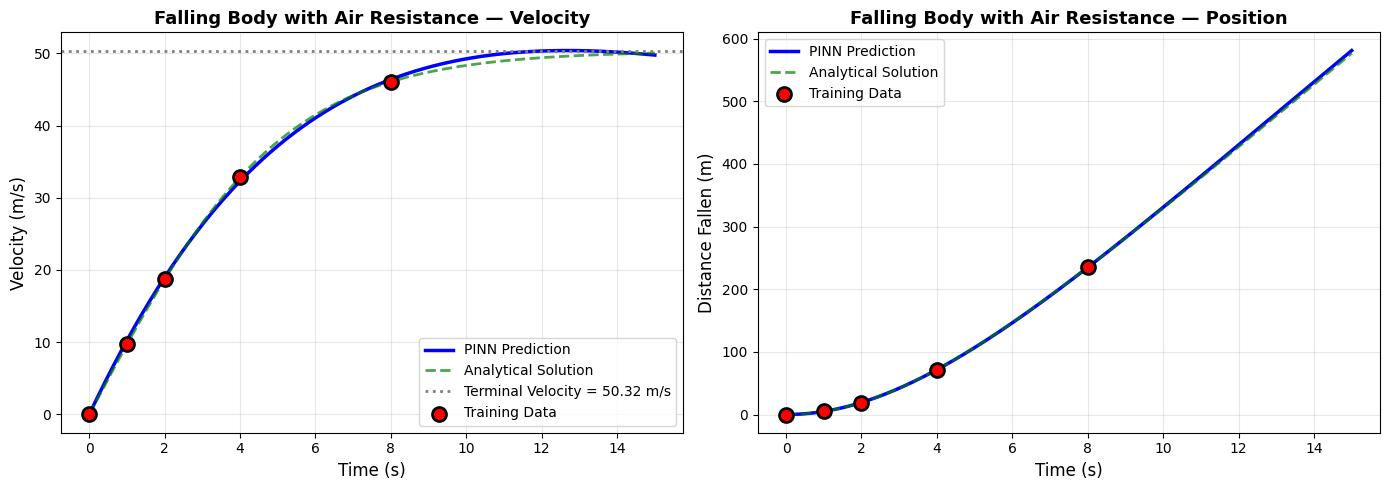

In [40]:
#8.
#visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

#used ai to make graphs prettier and more aesthetically pleasing
#velocity plot
ax1.plot(t_test_np, v_pred, 'b-', linewidth=2.5, label="PINN Prediction")
ax1.plot(t_test_np, v_true, 'g--', linewidth=2, alpha=0.7, label="Analytical Solution")
ax1.axhline(v_terminal, color='gray', linestyle=':', linewidth=2, 
            label=f"Terminal Velocity = {v_terminal:.2f} m/s")
ax1.scatter(t_data_np, v_data_np, color='red', s=100, zorder=5, 
            edgecolors='black', linewidth=2, label="Training Data")
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("Velocity (m/s)", fontsize=12)
ax1.set_title("Falling Body with Air Resistance — Velocity", fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

#position plot
ax2.plot(t_test_np, y_pred, 'b-', linewidth=2.5, label="PINN Prediction")
ax2.plot(t_test_np, y_true, 'g--', linewidth=2, alpha=0.7, label="Analytical Solution")
ax2.scatter(t_data_np, y_data_np, color='red', s=100, zorder=5, 
            edgecolors='black', linewidth=2, label="Training Data")
ax2.set_xlabel("Time (s)", fontsize=12)
ax2.set_ylabel("Distance Fallen (m)", fontsize=12)
ax2.set_title("Falling Body with Air Resistance — Position", fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

#plot
plt.tight_layout()
plt.show()


In [41]:
#9.
#performance metrics
v_terminal_pred = v_pred[-50:].mean()
v_mae = np.mean(np.abs(v_pred.flatten() - v_true))
y_mae = np.mean(np.abs(y_pred.flatten() - y_true))

#display results
print(f"Digital Twin Complete")
print(f"Terminal Velocity (theoretical):{v_terminal:.2f} m/s")
print(f"Terminal Velocity (PINN):{v_terminal_pred:.2f} m/s")
print(f"Velocity MAE:{v_mae:.3f} m/s")
print(f"Position MAE:{y_mae:.2f} m")

Digital Twin Complete
Terminal Velocity (theoretical):50.32 m/s
Terminal Velocity (PINN):50.17 m/s
Velocity MAE:0.506 m/s
Position MAE:1.23 m
